In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import math
matplotlib.rc('font', size=18)
import scipy
from sklearn.model_selection import KFold

In [26]:
# Smoothing functions
import scipy.signal as signal
def smooth_column(x, window, dtype):
    y = signal.convolve(x.astype(dtype),window,'same')
    return y
def smooth_spk(neural_data, gauss_width, bin_width,dtype="float64"):
    """ Smooth spikes by Gaussian kernel """
    gauss_bin_std = gauss_width / bin_width
    win_len = int(6*gauss_bin_std)
    window = signal.gaussian(win_len, gauss_bin_std, sym = True)
    window /= np.sum(window)
    smoothed_spikes = np.apply_along_axis(lambda x: smooth_column(x, window, dtype), 0, neural_data)
    return smoothed_spikes

In [27]:
# R2 function
def get_sses_pred(y_test,y_test_pred):
    sse=np.sum((y_test_pred-y_test)**2,axis=0)
    return sse
def get_sses_mean(y_test):
    y_mean=np.mean(y_test,axis=0)
    sse_mean=np.sum((y_test-y_mean)**2,axis=0)
    return sse_mean

In [28]:
# Data processing for cross-validation loops
def process_train_test(X,y,training_set,test_set):
    """ z-score X, mean-center Y"""
    X_train = X[training_set,:]
    X_test = X[test_set,:]
    y_train = y[training_set,:]
    y_test = y[test_set,:]

    X_train_mean=np.nanmean(X_train,axis=0)
    X_train_std=np.nanstd(X_train,axis=0)   
    y_train_mean=np.nanmean(y_train,axis=0)

    X_train=(X_train-X_train_mean)/X_train_std
    X_test=(X_test-X_train_mean)/X_train_std

    y_train=y_train-y_train_mean
    y_test=y_test-y_train_mean
    return X_train,X_test,y_train,y_test

In [29]:
# Auxiliary functions
def nans(shape, dtype=float):
    """ Returns array of NaNs with defined shape"""
    a = np.empty(shape, dtype)
    a.fill(np.nan)
    return a

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)
def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'"""
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

# Data loading and formatting 

In [30]:
import scipy.io as sio
foldername = "/Users/sherryan/area2_population_analysis/random-target/"
data = sio.loadmat(foldername+'s1_data_trialized.mat')

In [31]:
kinematics = data['acceleration']
neural_data = data['neural_data']

print(kinematics.shape,'kinematics')
print(neural_data.shape,'neural data')
n_trials = len(neural_data)
print(n_trials,'trials')
n_neurons = neural_data[0,0].shape[1]
print(n_neurons,'neurons')

# kinematics (Y) and neural_data (X) are shaped (n_trials,1) 
# each is an 1d array of 2d arrays; I did not use a 3d array so to allow for variable trial length

(942, 1) kinematics
(942, 1) neural data
942 trials
52 neurons


In [32]:
# each trial of neural data is shaped (n_bins, n_neurons)
# each trial of kinematics is shaped (n_bins, n_kinematic_features)

print('Data shape for the 1st trial:')
print(neural_data[0,0].shape)
print(kinematics[0,0].shape)
print('')
print('Data shape for the 2nd trial:')
print(neural_data[1,0].shape)
print(kinematics[1,0].shape)
print('')
print('Data shape for the 3rd trial:')
print(neural_data[2,0].shape)
print(kinematics[2,0].shape)


# Note: length of kinematics is the actual trial length,
# neural data should have more timepoints than kinematics to allow time-lagged decoding, can be wider than the range of time lags of interest
# i.e. here I'm interested in testing efferent/afferent signals between -300 to +300ms, but I got neural data -500ms to +500ms;
# which means I included 50 more timepoints prior to trial start (10-ms bin), and 50 more timepoints post trial end, thus in total 100 more timepoints

# let the model know the amount of previous/future bins are included in neural data
n_previous_bins = 50
n_future_bins = 50

Data shape for the 1st trial:
(154, 52)
(54, 2)

Data shape for the 2nd trial:
(235, 52)
(135, 2)

Data shape for the 3rd trial:
(241, 52)
(141, 2)


# Data smoothing (optional)

In [33]:
# # this data has 0.01 s = 10 ms bins 
# dt = 0.01
# gauss_width = 40 #in ms
# bin_width = dt*1000 #in ms

# # smooth neural data by 40-ms gaussian kernel
# neural_smth_40 = []
# for i in range(n_trials):
#     neural_d = neural_data[i,0]
#     smth_40 = smooth_spk(neural_d, gauss_width, bin_width)
#     neural_smth_40.append(smth_40)
# neural_smth_40 = np.array(neural_smth_40,dtype=object).reshape(n_trials,1)

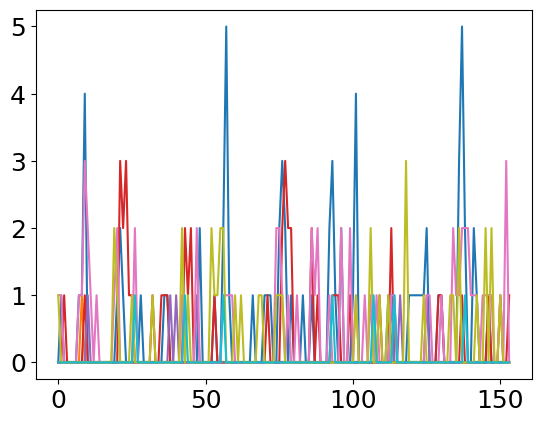

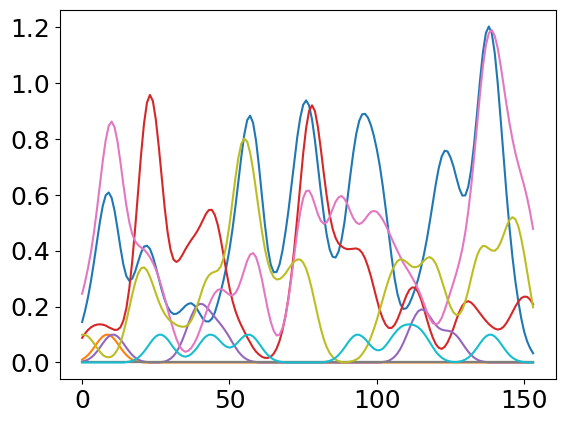

In [34]:
# #Check effects of smoothing for 10 neurons in the first trial
# plt.plot(neural_data[0,0][:,:10])
# plt.show()
# plt.plot(neural_smth_40[0,0][:,:10])
# plt.show()

# Fit the model

In [35]:
# MODIFY THIS PART

lag_axis = np.arange(-300, 300, 20) # array of time lags to try, here -300 to +300 ms with 20-ms step
bin_width = 10 #in ms
x = neural_smth_40
y = kinematics

filter = False #default filter option as False, can set in the next cell

n_total_datapoints = 0
for i in range(len(y)): 
    n_total_datapoints+=y[i,0].shape[0] # Count total number of data points to fit in model


In [36]:
#Helper functions
def flat_lagged_neural(x, n_previous_bins, n_future_bins, lagged_bins, n_total_datapoints):
    """ Flatten time-lagged & trial-ized neural data into 2d array """
    x_flat = nans([n_total_datapoints,n_neurons])    
    trial_save_idx = 0
    for tr in range(len(x)):
        trial_data = x[tr,0]
        start, end = int(n_previous_bins+lagged_bins), int(len(trial_data)-n_future_bins+lagged_bins)
        n = len(trial_data[start:end,:])
        x_flat[trial_save_idx:trial_save_idx+n,:] = trial_data[start:end,:]
        trial_save_idx+=n
    return x_flat
def flat_kinematics(y,n_total_timepoints):
    """ Flatten trial-ized kinematics into 2d array """
    y_flat = nans([n_total_timepoints,2])
    trial_save_idx = 0
    for tr in range(len(y)):
        n = len(y[tr,0])
        y_flat[trial_save_idx:trial_save_idx+n,:] = y[tr,0]
        trial_save_idx+=n
    return y_flat

In [37]:
# #OPTIONAL FILTER, filter out invalid nrns that are not very active during trial time
# filter = True
# x_flat = flat_lagged_neural(neural_data, n_previous_bins, n_future_bins, 0, n_total_datapoints)
# fr_thresh = 1 #threshold in Hz
# fr = np.sum(x_flat,axis=0)/x_flat.shape[0]*(1000/bin_width)
# neuron_filter = fr > fr_thresh
# print(neuron_filter)
# print(sum(~neuron_filter),'invalid neurons')

[ True  True False  True  True False  True False  True  True  True  True
 False  True  True False  True False  True  True  True False  True False
  True  True False  True  True False  True  True False  True False  True
 False  True  True False  True False  True False  True  True False  True
  True False  True False]
19 invalid neurons


In [38]:
y_flat = flat_kinematics(y, n_total_datapoints) #flatten y
y_proc = y_flat - np.nanmean(y_flat,axis=0) #mean-center y

#save R2, r, and coeffients across lags
r2_array = nans([len(lag_axis)])
r_array = nans([len(lag_axis)])
if filter:
    coef_array = nans([len(lag_axis),2,sum(neuron_filter)]) #OPTIONAL FILTER
else:
    coef_array = nans([len(lag_axis),2,n_neurons]) 

for i in range(len(lag_axis)):
    current_lagged_bins = lag_axis[i]/bin_width
    x_flat = flat_lagged_neural(x, n_previous_bins, n_future_bins, current_lagged_bins, n_total_datapoints) #flatten x
    if filter:
        x_flat = x_flat[:,neuron_filter] #OPTIONAL FILTER
    x_proc = (x_flat - np.nanmean(x_flat,axis=0))/np.nanstd(x_flat,axis=0) #z-score x

    lr_all = GridSearchCV(Ridge(),{'alpha':np.logspace(-3, 3, 7)}) #Grid-search penalty term for Ridge regularization
    lr_all.fit(x_proc, y_proc)
    coef_array[i,:,:] = lr_all.best_estimator_.coef_ #Save model's coefficient as fitted to all data points

    #Cross-validate R2
    kf = KFold(n_splits=5, shuffle=False) #Simple 5-fold CV (not the most rigorous); no shuffle, otherwise there'll be too much leakage across trials
    true_concat = nans([n_total_datapoints,2])
    pred_concat = nans([n_total_datapoints,2]) #Concatenate true and predicted kinematics for final R2 calculation
    save_idx = 0
    for training_set, test_set in kf.split(range(0,len(x_flat))):
        X_train, X_test, y_train, y_test = process_train_test(x_flat,y_flat,training_set,test_set)
        lr = GridSearchCV(Ridge(),{'alpha':np.logspace(-3, 3, 7)})
        lr.fit(X_train, y_train)
        y_test_predicted = lr.predict(X_test)
        n = y_test_predicted.shape[0]
        true_concat[save_idx:save_idx+n,:] = y_test
        pred_concat[save_idx:save_idx+n,:] = y_test_predicted
        save_idx += n
    # r2 across features
    sses =get_sses_pred(true_concat,pred_concat)
    sses_mean=get_sses_mean(true_concat)
    r2 =1-np.sum(sses)/np.sum(sses_mean)     
    # mean spearman's r across features
    rs = []
    for feature in range(y_flat.shape[1]):
        rs.append(scipy.stats.spearmanr(pred_concat[:,feature], true_concat[:,feature]).correlation)
    r = np.mean(rs) 
    r2_array[i] = r2; r_array[i] = r;

# See results

Text(0, 0.5, 'R2')

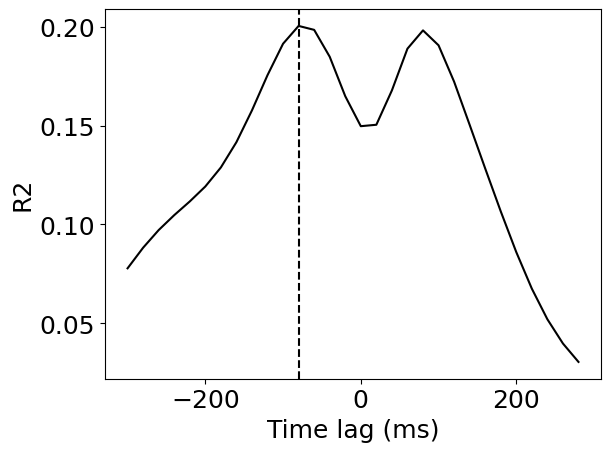

In [39]:
# R2 across lags (are there two peaks?)
idx_max = np.argmax(r2_array)
plt.plot(lag_axis,r2_array, color = 'k')
plt.axvline(lag_axis[idx_max],color = 'k',linestyle='--')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')

Text(0, 0.5, 'Correlation')

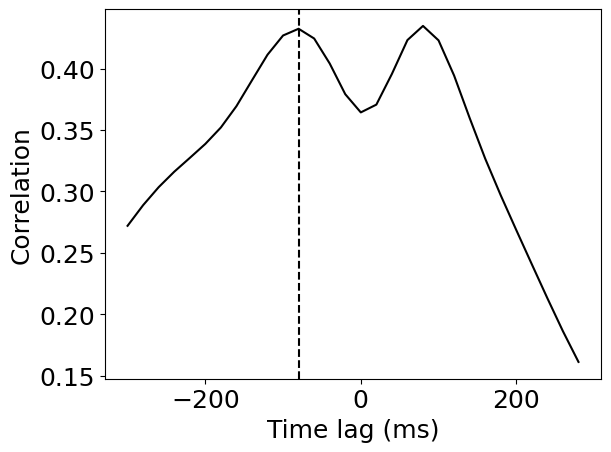

In [40]:
# Correlation across lags
plt.plot(lag_axis,r_array, color = 'k')
plt.axvline(lag_axis[idx_max],color = 'k',linestyle='--')
plt.xlabel('Time lag (ms)')
plt.ylabel('Correlation')

Text(0, 0.5, 'Angle (degrees)')

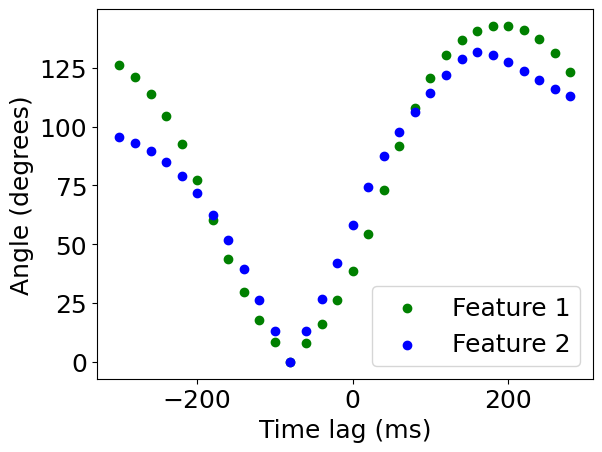

In [41]:
# Angle between decoder at each lag with the best decoder (relationship between decoders across lags)
idx_max = np.argmax(r2_array)
ang_to_max_0 = nans([len(lag_axis)])
ang_to_max_1 = nans([len(lag_axis)])
for i in range(0, len(coef_array)):
    ang_to_max_0[i] = math.degrees(angle_between(coef_array[i,0,:],coef_array[idx_max,0,:]))
    ang_to_max_1[i] = math.degrees(angle_between(coef_array[i,1,:],coef_array[idx_max,1,:]))
plt.scatter(lag_axis, ang_to_max_0,label = 'Feature 1',color = 'green')
plt.scatter(lag_axis, ang_to_max_1,label = 'Feature 2',color = 'blue')
plt.legend()
plt.xlabel('Time lag (ms)')
plt.ylabel('Angle (degrees)')

In [42]:
# Refit with projection out
def calc_proj_matrix(A):
    return A@np.linalg.inv(A.T@A)@A.T
def calc_proj(R, w):
    """ Returns projection of R onto the space defined by w """
    P = calc_proj_matrix(w)
    return P@R.T

best_decoder = coef_array[idx_max,:,:]
proj_r2_array = nans([len(lag_axis)])
proj_r_array = nans([len(lag_axis)])

for i in range(len(lag_axis)):
    current_lagged_bins = lag_axis[i]/bin_width
    x_flat = flat_lagged_neural(x, n_previous_bins, n_future_bins, current_lagged_bins, n_total_datapoints) #flatten x
    if filter:
        x_flat = x_flat[:,neuron_filter] #OPTIONAL
    x_proc = (x_flat - np.nanmean(x_flat,axis=0))/np.nanstd(x_flat,axis=0) #z-score x
    x_sub = x_proc - calc_proj(x_proc,best_decoder.T).T
    x_new = x_sub * np.nanstd(x_flat,axis=0) + np.nanmean(x_flat,axis=0)

    #Cross-validate R2
    kf = KFold(n_splits=5, shuffle=False) #Simple 5-fold CV (not the most rigorous); no shuffle, otherwise there'll be too much leakage across trials
    true_concat = nans([n_total_datapoints,2])
    pred_concat = nans([n_total_datapoints,2]) #Concatenate true and predicted kinematics for final R2 calculation
    save_idx = 0
    for training_set, test_set in kf.split(range(0,len(x_new))):
        X_train, X_test, y_train, y_test = process_train_test(x_new,y_flat,training_set,test_set)
        lr = GridSearchCV(Ridge(),{'alpha':np.logspace(-3, 3, 7)})
        lr.fit(X_train, y_train)
        y_test_predicted = lr.predict(X_test)
        n = y_test_predicted.shape[0]
        true_concat[save_idx:save_idx+n,:] = y_test
        pred_concat[save_idx:save_idx+n,:] = y_test_predicted
        save_idx += n
    # r2 across features
    sses =get_sses_pred(true_concat,pred_concat)
    sses_mean=get_sses_mean(true_concat)
    r2 =1-np.sum(sses)/np.sum(sses_mean)     
    # mean spearman's r across features
    rs = []
    for feature in range(y_flat.shape[1]):
        rs.append(scipy.stats.spearmanr(pred_concat[:,feature], true_concat[:,feature]).correlation)
    r = np.mean(rs) 
    proj_r2_array[i] = r2; proj_r_array[i] = r;

Text(0, 0.5, 'R2')

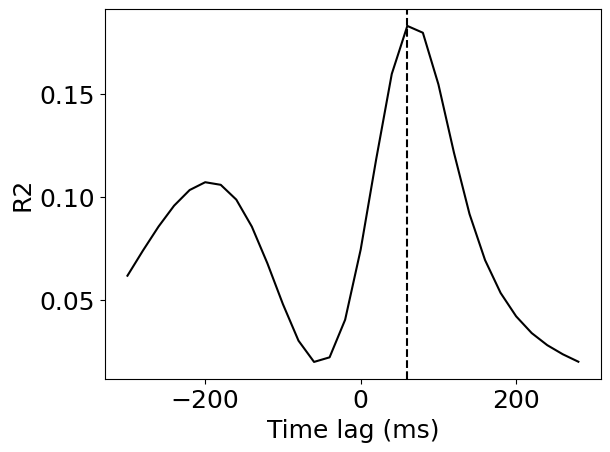

In [43]:
# R2 across lags after projection out
idx_max = np.argmax(proj_r2_array)
plt.plot(lag_axis,proj_r2_array, color = 'k')
plt.axvline(lag_axis[idx_max],color = 'k',linestyle='--')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')

Text(0, 0.5, 'Correlation')

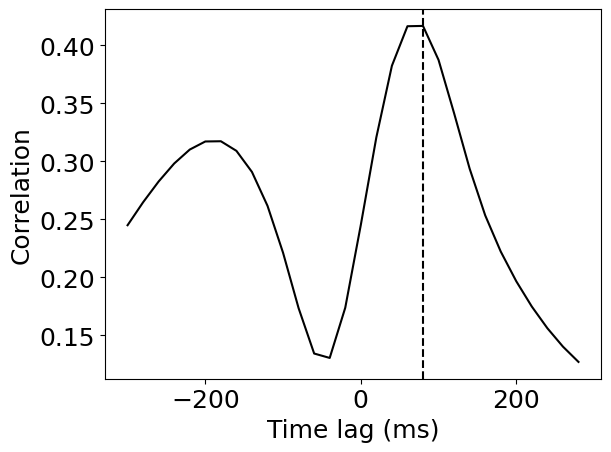

In [44]:
# Correlation across lags after projection out
idx_max = np.argmax(proj_r_array)
plt.plot(lag_axis,proj_r_array, color = 'k')
plt.axvline(lag_axis[idx_max],color = 'k',linestyle='--')
plt.xlabel('Time lag (ms)')
plt.ylabel('Correlation')